# Decision Trees


Decision trees are yet another type of classifier that we can use similarly to how we use Naive Bayesian classifiers. They work very differently, though.

It's basically a tree of if-statements to come up with a classification, and we can definitely code them by hand.

In [1]:
from collections import Counter, defaultdict, namedtuple
from functools import partial
import math, random

In [2]:
%install_ext https://raw.github.com/tkf/ipython-hierarchymagic/master/hierarchymagic.py

Installed hierarchymagic.py. To use it, type:
  %load_ext hierarchymagic


/Users/james/src/github.com/tiyd-python-2015-08/course-resources/.direnv/python-3.4.3/lib/python3.4/site-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension(s)as a python packages.
  "as a python packages.", UserWarning)


In [3]:
%load_ext hierarchymagic

In [4]:
Animal = namedtuple('Animal', 'has_backbone,cold_blooded,born_in_water,lungs_as_adult,milk_drinker')

crow = Animal(True, False, False, True, False)
bass = Animal(True, True, True, False, False)
spider = Animal(False, False, False, True, False)
rattlesnake = Animal(True, True, False, True, False)

def animal_type(animal):
    if animal.has_backbone:
        if animal.cold_blooded:
            if animal.born_in_water:
                if animal.lungs_as_adult:
                    return 'amphibian'
                else:
                    return 'fish'
            else:
                return 'reptile'
        else:
            if animal.milk_drinker:
                return 'mammal'
            else:
                return 'bird'
    else:
        return 'invertebrate'



In [5]:
animal_type(spider)

'invertebrate'

In [6]:
animal_type(bass)

'fish'

In [7]:
animal_type(crow)

'bird'

In [8]:
animal_type(rattlesnake)

'reptile'

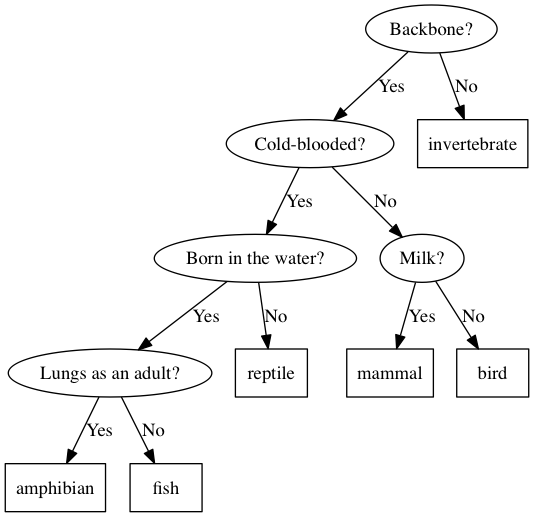

In [62]:
%%dot
digraph animal_type {
    A [label="Backbone?"]
    B [label="Cold-blooded?"]
    C [label="Born in the water?"]
    D [label="Lungs as an adult?"]
    E [label="Milk?"]
    invertebrate, amphibian, fish, reptile, mammal, bird [shape=rectangle]
    A -> B [label=Yes]
    A -> invertebrate [label=No]
    B -> C [label=Yes]
    C -> D [label=Yes]
    C -> reptile [label=No]
    D -> fish [label=No]
    D -> amphibian [label=Yes]
    B -> E [label=No]
    E -> mammal [label=Yes]
    E -> bird [label=No]
}

It's not practical for us to create decision trees by hand when we're dealing with large sets of data or large numbers of columns.

So we acn use an algorithm to build our decision trees for us.

It works by looking at the different features a data set could be split on, and then choosing attributes that produce the least _entropy_. That is, it generates the most uniform subset. Each subset is then partitioned further until it's able to reach a subset that is completely uniform, OR there are no more features to partition with.

Let's write some code to find entropy of a dataset. The data should be a list of tuples, with each tuple having a feature vector and a label.

Just trust me on the math.

We'll use some data about mushrooms: https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/




In [11]:
def entropy(class_probabilities):
    return sum(-p * math.log(p, 2) for p in class_probabilities if p)

def class_probabilities(labels):
    total_count = len(labels)
    return [count / total_count for count in Counter(labels).values()]

def data_entropy(labeled_data):
    labels = [label for _, label in labeled_data]
    probabilities = class_probabilities(labels)
    return entropy(probabilities)

In [14]:
import csv

mushroom_data = []
columns = ["poisonous", "cap-shape", "cap-surface", "cap-color", "bruises", "odor", 
           "gill-attachment", "gill-spacing", "gill-size", "gill-color", 
           "stalk-shape", "stalk-root",  "stalk-surface-above-ring", 
           "stalk-surface-below-ring", "stalk-color-above-ring", 
           "stalk-color-below-ring", "veil-type", "veil-color", "ring-number", 
           "ring-type", "spore-print-color", "population", "habitat"]
with open('agaricus-lepiota.data') as f:
    reader = csv.DictReader(f, fieldnames=columns)
    for row in reader:
        
        poisonous = row.pop('poisonous')
        if poisonous == 'p':
            poisonous = True
        else:
            poisonous = False
        
        mushroom_data.append((row, poisonous))

print(len(mushroom_data))
data_entropy(mushroom_data)

8124


0.9990678968724604

We need to try partitioning our data, so we can calculate the entropy of each potential subset

In [15]:
def partition_by(inputs, attribute):
    '''return a dict of inputs partitioned by the attribute
    each input is a pair (attribute_dict, label)
    '''
    groups = defaultdict(list)
    for item in inputs:
        key = item[0][attribute]
        groups[key].append(item)
    return groups

def partition_entropy(subsets):
    '''find the entropy from this partition of data into subsets'''
    total_count = sum(len(subset) for subset in subsets)
    
    return sum(data_entropy(subset) * len(subset) / total_count
               for subset in subsets)

def partition_entropy_by(inputs, attribute):
    '''compute the entropy corresponding to the given partition'''
    partitions = partition_by(inputs, attribute)
    return partition_entropy(partitions.values())


In [21]:
feature_names = columns[1:]
res = []
for feature in feature_names:
#     print(feature, partition_entropy_by(mushroom_data, feature))
    res.append((feature, partition_entropy_by(mushroom_data, feature)))

print(sorted(res, key=lambda x: x[1]))

[('odor', 0.09299291948846061), ('spore-print-color', 0.5183629791875449), ('gill-color', 0.582090373456329), ('ring-type', 0.6810463860789229), ('stalk-surface-above-ring', 0.7143422976539759), ('stalk-surface-below-ring', 0.7271734234797139), ('stalk-color-above-ring', 0.7452227234102206), ('stalk-color-below-ring', 0.757652330344894), ('gill-size', 0.7689135217244145), ('population', 0.7971098778056078), ('bruises', 0.8066884111112408), ('habitat', 0.8422342922673683), ('stalk-root', 0.8642502592451846), ('gill-spacing', 0.8981847128758902), ('cap-shape', 0.9502711949370874), ('ring-number', 0.96061522762937), ('cap-color', 0.9630186138962565), ('cap-surface', 0.9704776640986876), ('veil-color', 0.9752508807515435), ('gill-attachment', 0.9849028696218443), ('stalk-shape', 0.991551124302796), ('veil-type', 0.9990678968724604)]


## Building a decision tree

To actually build the tree, we need to use some sort of algorithm to make decisions about which partitions to use. We're going to use something called the [ID3 algorithm](https://en.wikipedia.org/wiki/ID3_algorithm)

Steps:
1. Calculate the entropy of every attribute using the data set S
1. Split the set S into subsets using the attribute that has the minimum entropy from step 1
1. Make a decision tree node containing that attribute
1. Recur on subsets using the remaining attributes

For our implementation, we'll have a tree be either a label or a tuple `(attribute, subtree_dict)`. `subtree_dict` has the possible values for the attribute as keys and the subtrees as values.

In [22]:
mushroom_data[:5]

[({'bruises': 't',
   'cap-color': 'n',
   'cap-shape': 'x',
   'cap-surface': 's',
   'gill-attachment': 'f',
   'gill-color': 'k',
   'gill-size': 'n',
   'gill-spacing': 'c',
   'habitat': 'u',
   'odor': 'p',
   'population': 's',
   'ring-number': 'o',
   'ring-type': 'p',
   'spore-print-color': 'k',
   'stalk-color-above-ring': 'w',
   'stalk-color-below-ring': 'w',
   'stalk-root': 'e',
   'stalk-shape': 'e',
   'stalk-surface-above-ring': 's',
   'stalk-surface-below-ring': 's',
   'veil-color': 'w',
   'veil-type': 'p'},
  True),
 ({'bruises': 't',
   'cap-color': 'y',
   'cap-shape': 'x',
   'cap-surface': 's',
   'gill-attachment': 'f',
   'gill-color': 'k',
   'gill-size': 'b',
   'gill-spacing': 'c',
   'habitat': 'g',
   'odor': 'a',
   'population': 'n',
   'ring-number': 'o',
   'ring-type': 'p',
   'spore-print-color': 'n',
   'stalk-color-above-ring': 'w',
   'stalk-color-below-ring': 'w',
   'stalk-root': 'c',
   'stalk-shape': 'e',
   'stalk-surface-above-ring': 's

In [23]:
def build_tree_id3(inputs, split_candidates=None):
    
    # all the keys of our first input are considered split_candidates
    if split_candidates is None:
        split_candidates = inputs[0][0].keys()
        
    # count up our labels in the inputs
    num_inputs = len(inputs)
    label_counter = Counter([label for item, label in inputs])
    most_common = label_counter.most_common()[0][0]
    
    if len(label_counter.keys()) == 1: # no need to look deeper
        return most_common
    
    if not split_candidates: # no candidates left
        return most_common
    
    # otherwise, split on the best attribute
    best_attribute = min(split_candidates,
                         key=partial(partition_entropy_by, inputs))
    
    partitions = partition_by(inputs, best_attribute)
    new_candidates = [a for a in split_candidates if a != best_attribute]
    
    # recurse!
    subtrees = {attribute: build_tree_id3(subset, new_candidates)
                for attribute, subset in partitions.items()}
    
    subtrees[None] = most_common
    
    return (best_attribute, subtrees)
    

In [24]:
build_tree_id3(mushroom_data)

('odor',
 {'p': True,
  'n': ('spore-print-color',
   {'n': False,
    'r': True,
    'h': False,
    'o': False,
    'w': ('habitat',
     {'p': False,
      None: False,
      'w': False,
      'g': False,
      'd': ('stalk-root', {'?': True, None: True, 'b': False}),
      'l': ('stalk-color-below-ring',
       {'n': False, None: False, 'w': True, 'y': True})}),
    'b': False,
    None: False,
    'y': False,
    'k': False}),
  None: False,
  'c': True,
  'l': False,
  's': True,
  'f': True,
  'm': True,
  'a': False,
  'y': True})

In [37]:
def classify(tree, sample):
    '''walk the tree using the specified input'''
    
    # base case / endpoint
    if type(tree) != tuple:
        return tree
    
    # otherwise, pick the right subtree
    attribute, subtree_dict = tree
    
    subtree_key = sample.get(attribute) # pull out the attribute
    
    if subtree_key not in subtree_dict: # if it's not in the subtree
        subtree_key = None              # use the None subtree
    
    subtree = subtree_dict[subtree_key] # pull out the correct subtree
    return classify(subtree, sample)    # recurse!


In [27]:
tree = build_tree_id3(mushroom_data)
classify(tree, mushroom_data[0][0])

True

In [28]:
class DecisionTree:
    def __init__(self):
        self.tree = None
    
    def fit(self, X, y):
        self.tree = build_tree_id3(list(zip(X, y)))
        return self
    
    def predict(self, X):
        results = []
        for x in X:
            results.append(classify(self.tree, x))
        return results
    
    def score(self, X, y):
        results = self.predict(X)
        correct = 0
        for i in range(len(y)):
            if y[i] == results[i]:
                correct += 1
        
        return correct / len(y)


In [30]:
def unzip(data):
    return [d[0] for d in data], [d[1] for d in data]

from sklearn.cross_validation import train_test_split

X, y = unzip(mushroom_data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

tree = DecisionTree()
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

1.0

Most of the time we don't expect to have a complete data set, and therefore we don't expect a classifier to be 100% accurate. In this case, we do, because there are only 23 different species that have been classified.

Let's consider a company looking to hire developers that wants to look at past candidates' data and whether or not those candidates ended up being good employees.

In [31]:
hires = [
    ({'level':'Senior','lang':'Java','tweets':'no','phd':'no'},   False),
    ({'level':'Senior','lang':'Java','tweets':'no','phd':'yes'},  False),
    ({'level':'Mid','lang':'Python','tweets':'no','phd':'no'},     True),
    ({'level':'Junior','lang':'Python','tweets':'no','phd':'no'},  True),
    ({'level':'Junior','lang':'R','tweets':'yes','phd':'no'},      True),
    ({'level':'Junior','lang':'R','tweets':'yes','phd':'yes'},    False),
    ({'level':'Mid','lang':'R','tweets':'yes','phd':'yes'},        True),
    ({'level':'Senior','lang':'Python','tweets':'no','phd':'no'}, False),
    ({'level':'Senior','lang':'R','tweets':'yes','phd':'no'},      True),
    ({'level':'Junior','lang':'Python','tweets':'yes','phd':'no'}, True),
    ({'level':'Senior','lang':'Python','tweets':'yes','phd':'yes'},True),
    ({'level':'Mid','lang':'Python','tweets':'no','phd':'yes'},    True),
    ({'level':'Mid','lang':'Java','tweets':'yes','phd':'no'},      True),
    ({'level':'Junior','lang':'Python','tweets':'no','phd':'yes'},False)
]



In [32]:
tree = build_tree_id3(hires)

In [33]:
tree

('level',
 {'Senior': ('tweets', {'yes': True, 'no': False, None: False}),
  'Mid': True,
  None: True,
  'Junior': ('phd', {'yes': False, 'no': True, None: True})})

In [38]:
classify(tree, {'lang': 'Python', 'tweets': 'yes', 'phd': 'yes'})

True

Our `DecisionTree` is cool, it works kind of like SciKit-learn stuff does, but it's limited - it can't handle continuous data, and that's a problem for a lot of data.

However, there's something in SciKit-Learn that builds decision trees for us, and can also handle continuous data.

In [41]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

# load in some credit card data from https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/

credit_data = pd.read_csv('crx.data', header=None, na_values=['?'])
credit_data = credit_data.dropna()


X = credit_data.loc[:, 0:14]
y = credit_data[15]
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202,0
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43,560
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280,824
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100,3
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120,0


In [42]:
y.head()

0    +
1    +
2    +
3    +
4    +
Name: 15, dtype: object

In [43]:
X = pd.get_dummies(X)
X.head()

,1,2,7,10,13,14,0_a,0_b,3_l,3_u,...,6_z,8_f,8_t,9_f,9_t,11_f,11_t,12_g,12_p,12_s
0,30.83,0.000,1.25,1,202,0,0,1,0,1,...,0,0,1,0,1,1,0,1,0,0
1,58.67,4.460,3.04,6,43,560,1,0,0,1,...,0,0,1,0,1,1,0,1,0,0
2,24.50,0.500,1.50,0,280,824,1,0,0,1,...,0,0,1,1,0,1,0,1,0,0
3,27.83,1.540,3.75,5,100,3,0,1,0,1,...,0,0,1,0,1,0,1,1,0,0
4,20.17,5.625,1.71,0,120,0,0,1,0,1,...,0,0,1,1,0,1,0,0,0,1


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.82317073170731703

In [45]:
y.head()

0    +
1    +
2    +
3    +
4    +
Name: 15, dtype: object

In [46]:
from sklearn.naive_bayes import MultinomialNB

# tree = ()
# tree.fit(X_train, y_train)
# tree.score(X_test, y_test)

bayes = MultinomialNB()
bayes.fit(X_train, y_train)
bayes.score(X_test, y_test)

0.68292682926829273

In [47]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file='tree.dot')

In [48]:
!dot tree.dot -Tpng -o tree.png

In [49]:
!open tree.png

Gini: https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity

## Random Forest Classifier

Yet another decision-tree based classified is called the _Random Forest Classifier_. It makes multiple decision trees, each leaving out some of the available features. When classifying, it asks all the decision trees for their "votes" for a given input, and goes with the highest voted option.


In [58]:
from sklearn.ensemble import RandomForestClassifier

random_tree = RandomForestClassifier()

random_tree.fit(X_train, y_train)
random_tree.score(X_test, y_test)

0.86585365853658536

In [59]:
tree.score(X_test, y_test)

0.82317073170731703